In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import json
import nltk

%matplotlib inline

In [2]:
path_to_data = './data'

# create dataframe from sessions.json
df = pd.read_json(f'{path_to_data}/sessions/sessions_03_17.json')
df.head()

# create dictionaries for switching between symptom and id
id2sym = {}
sym2id = {}

# create dictionary containing all relevant information of the symptoms
sym_info = {}

with open(f'{path_to_data}/symptoms/symptoms_03_17.json') as json_file:
    data = json.load(json_file)
    for sym in data:
        id2sym[sym['id']] = sym['name']
        sym2id[sym['name']] = sym['id']
        
        sym_info[sym['name']] = sym

print(f'Numer of symptoms in id2sym: {len(sym2id)}')

if False:
    # remove labels that have less than m occurrences
    m = 100

    labels_list = df['all_confirmed'].tolist()
    labels_list = sum(labels_list, [])
    c = Counter(labels_list)
    for i in range(len(df)):
        to_remove = []
        
        # find labels that should be removed 
        for j in range(len(df['all_confirmed'][i])):
            if c[df['all_confirmed'][i][j]] < m:
                to_remove.append(j)
                
        # remove the labels
        shift = 0
        for j in range(len(to_remove)):
            df['all_confirmed'][i].pop(to_remove[j]-shift)
            shift += 1

# column that should be used as labels
label_col = 'confirmed'
        
# add column with the symptom names
sym_names = []

for syms in df[label_col]:
    if len(syms) != 0:
        sym_names.append([id2sym[x] for x in syms])
    else:
        sym_names.append([])

df['labels'] = sym_names

# turn suggested column into symptom names
sym_names = []

for syms in df['suggested']:
    if len(syms) != 0:
        sym_names.append([id2sym[x] for x in syms if x in id2sym])
    else:
        sym_names.append([])

df['suggested'] = sym_names
    

# remove all rows with no confirmed labels
df = df[df[label_col].map(len) > 0]
df = df.reset_index(drop=True)

# remove unused columns
df.drop('confirmed', inplace=True, axis=1)
df.drop('all_confirmed', inplace=True, axis=1)
#df.drop('suggested', inplace=True, axis=1)

Numer of symptoms in id2sym: 479


In [3]:
df.head()

,text,sex,age,suggested,labels
0,Slut på medicin.,Man,35,[Nyinsatta läkemedel],[Känd astma]
1,Jag har hostat snart 3 veckor. Snorar fram och...,Kvinna,37,"[Snuva, Hosta]","[Snuva, Hosta]"
2,Gissar att det är hasselallergi. Stora besvär ...,Man,60,"[Kissar ofta, Sveda vid miktion, Synliga hudbe...","[Tårande ögon, Synliga hudbesvär]"
3,Båda pappa och son hostar,Man,3,[Hosta],[Produktiv hosta]
4,H,Kvinna,30,[],[Hosta]


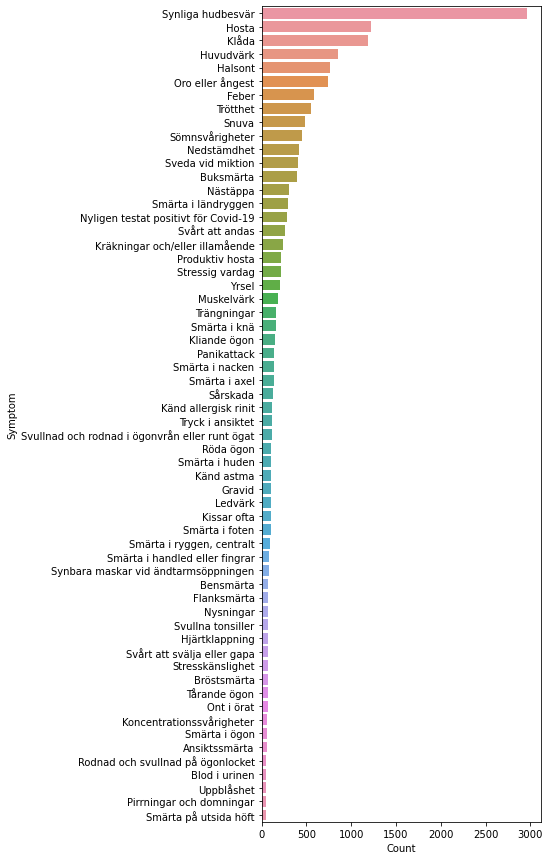

In [4]:
# plot the distribution of labels
all_syms = sum(df['labels'].tolist(),[])
all_syms = nltk.FreqDist(all_syms)

all_syms_df = pd.DataFrame({'Symptom': list(all_syms.keys()),
                            'Count': list(all_syms.values())
                           })

g = all_syms_df.nlargest(columns='Count', n=60)
plt.figure(figsize=(5,15))
ax = sns.barplot(data=g, x='Count', y='Symptom')

1:	 60.70 %
2:	 22.79 %
4:	 4.13 %
3:	 9.73 %
6:	 0.61 %
5:	 1.58 %
7:	 0.28 %
9:	 0.04 %
10:	 0.04 %
8:	 0.10 %
11:	 0.01 %


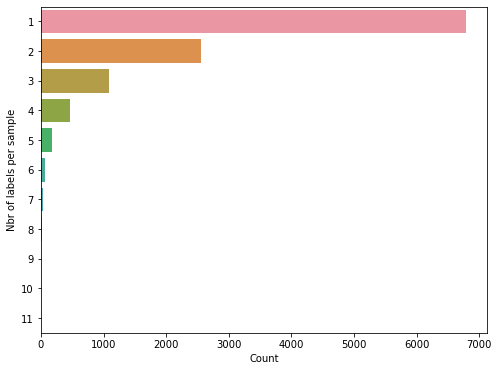

In [5]:
# plot the distribution of number of labels per sample
count_list = []

for sym_list in df['labels']:
    count_list.append(f'{len(sym_list)}')
    
count_dict = nltk.FreqDist(count_list)
count_dict_df = pd.DataFrame({'Nbr of labels per sample': list(count_dict.keys()),
                              'Count': list(count_dict.values())
                             })

# print percentages
count_dict_df = count_dict_df.sort_values(by=['Count'])
tot_samples = sum(count_dict_df['Count'].tolist())
for i in range(len(count_dict_df)):
    print(f'{count_dict_df["Nbr of labels per sample"][i]}:\t {count_dict_df["Count"][i] / tot_samples * 100:.2f} %')

g = count_dict_df.nlargest(columns='Count', n=60)

plt.figure(figsize=(8,6))
ax = sns.barplot(data=g, x='Count', y='Nbr of labels per sample')

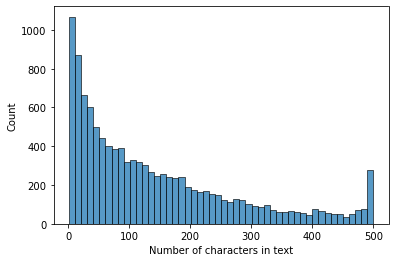

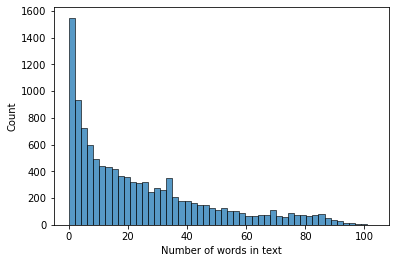

In [6]:
def clean_text(text):
    # turn text to lowercase
    text = text.lower()
    
    # remove all characters that are not letters or whitespace
    text = re.sub(r'[^\p{L} ]', '', text)
    
    return text

# plot the distribution of text lengths
length_list = []

for text in df['text']:
    length_list.append(len(text))

length_list_df = pd.DataFrame({'Number of characters in text': length_list})

ax = sns.histplot(data=length_list_df, x='Number of characters in text', bins=50)
plt.show()

# plot the distribution of words per text
word_count_list = []

for text in df['text']:
    text = clean_text(text)
    word_count_list.append(len(text.split()))
    
word_count_df = pd.DataFrame({'Number of words in text': word_count_list})

ax = sns.histplot(data=word_count_df, x='Number of words in text', bins=50)
plt.show()

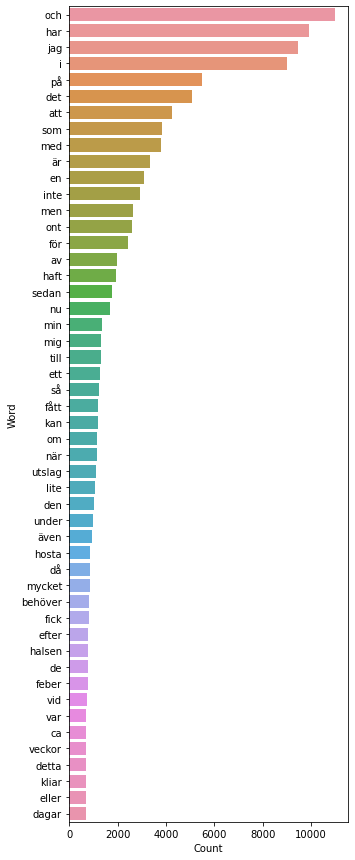

In [7]:
# plot the distribution of words
words = df['text'].tolist()
all_words = [clean_text(x).split() for x in words]
all_words = sum(all_words,[])
all_words = nltk.FreqDist(all_words)

all_words_df = pd.DataFrame({'Word': list(all_words.keys()),
                            'Count': list(all_words.values())
                           })

g = all_words_df.nlargest(columns='Count', n=50)
plt.figure(figsize=(5,15))
ax = sns.barplot(data=g, x='Count', y='Word')

In [8]:
# further explore the distribution of labels
labels = df['labels'].tolist()

multilab_bin = MultiLabelBinarizer()
y = multilab_bin.fit_transform(labels)

label_counts = np.sum(y, axis=0)
label_counts = np.flip(np.sort(label_counts))
print('Number of occurrences per label:')
print(label_counts)

n = 20
accum_per = np.sum([label_counts[:n]]) / np.sum(label_counts) * 100
print(f'The {n} most common labels make up {accum_per:.2f} % of all label occurrences')

m = 5
below_m = label_counts[label_counts < m]
print(f'{len(below_m)}/{len(label_counts)} labels have less than {m} occurrences')

Number of occurrences per label:
[2965 1223 1187  856  760  743  583  556  486  449  422  403  391  302
  291  286  258  237  221  216  201  182  157  156  153  143  143  141
  129  120  118  111  110  109  107  107  106  106  101   96   88   82
   77   77   76   74   74   73   72   70   67   67   66   64   58   54
   53   50   47   46   45   43   43   40   40   37   37   36   35   35
   33   32   32   31   30   30   30   30   30   30   29   29   28   25
   25   25   23   21   21   21   21   21   20   20   20   20   19   19
   19   18   18   18   18   18   18   18   17   17   17   16   15   15
   14   14   14   12   12   12   11   11   11   11   10   10   10   10
    9    9    9    9    9    9    9    9    8    8    8    8    8    7
    7    7    7    7    7    7    7    6    6    6    6    6    6    6
    6    6    6    6    5    5    5    5    5    4    4    4    4    4
    4    3    3    3    3    3    3    3    3    3    3    3    3    3
    3    3    3    3    3    3    3    3    

In [ ]:
# find duplicates in dataset
dup_count = 0
dup_text_count = {}

# get dict with symptom to counts
sym_counts = {}
for i in range(len(all_syms_df)):
    sym_counts[all_syms_df['Symptom'][i]] = all_syms_df['Count'][i]

check_set = set()

for i in range(len(df)):
    if df['labels'][i] == []:
        continue
    
    if (df['text'][i], tuple(df['labels'][i])) in check_set: 
        if df['labels'][i] != []:#: and len(df['text'][i]) > 50:
            #print(f'{df["text"][i]}\n{df["labels"][i]}')#'\n({check_dict[df["text"][i]][0]},{i})')
            #for j in range(len(df['labels'][i])):
            #    print(f"{df['labels'][i][j]}: {sym_counts[df['labels'][i][j]]}")
            #print()
            dup_count += 1
            
            if df['text'][i] in dup_text_count:
                dup_text_count[df['text'][i]] += 1
            else:
                dup_text_count[df['text'][i]] = 1
    else:
        check_set.add((df['text'][i], tuple(df['labels'][i])))
        
print(dup_count)

# print duplicates and their respective number of occurrences
for key, val in dup_text_count.items():
    print(f'{key}\n{val}\n')

In [ ]:
# observe potential connections between age and symptom

# dictionary containing lists of ages for each symptom
sym2info = {}

all_info = {'age': [], 'gen': []}

for i in range(len(df)):
    age = df['age'][i]
    gen = df['sex'][i]
    
    for sym in df['labels'][i]:
        if sym in sym2info:
            sym2info[sym]['age'].append(age)
            sym2info[sym]['gen'].append(gen)
        else:
            sym2info[sym] = {'age': [age], 'gen': [gen]}
            
    all_info['age'].append(age)
    all_info['gen'].append(gen)
    
    if age > 1000:
        print(age)
    
#print(np.mean(sym2info['Hosta']['age']))
    
palette ={"Kvinna": "C0", "Man": "C1", "Annat": "C2"}
order = ['Kvinna', 'Man', 'Annat']

plt.figure()
plt.subplot(1,2,1)
ax = sns.histplot(data=all_info, x='age', bins=25)
ax.set_xlabel('Age')
ax.set_title('All symptoms')

plt.subplot(1,2,2)
ax = sns.countplot(data=all_info, x='gen', palette=palette, order=order)

plt.show()
    
# symptom to observe
sym = 'Hosta'

zipped = [(multilab_bin.classes_[i], label_counts[i]) for i in range(len(multilab_bin.classes_))]
zipped = sorted(zipped, key=lambda tup: tup[1], reverse=True)


for i in range(len(zipped)):
    sym = zipped[i][0]
    
    plt.figure()
    plt.subplot(1,2,1)
    ax = sns.histplot(data=sym2info[sym], x='age', bins=25)
    ax.set_xlabel('Age')
    ax.set_title(sym)
    
    plt.subplot(1,2,2)
    ax = sns.countplot(data=sym2info[sym], x='gen', palette=palette, order=order)
    plt.show()

In [ ]:
# compute correlation matrix for the labels

from string import ascii_letters

rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# create dataframe containing the labels
lab_df = pd.DataFrame(y)
lab_df.columns = multilab_bin.classes_

# compute the correlation matrix
corr = lab_df.corr()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# set up the matplotlib figure
#f, ax = plt.subplots(figsize=(11,9))
f, ax = plt.subplots(figsize=(11,9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=3, center=0,
           square=True, linewidth=.5, cbar_kws={'shrink': .5})


corr = corr.abs()
s = corr.unstack()
so = s.sort_values(kind='quicksort')
#so = so[:-(len(multilab_bin.classes_))]

# set to keep track of what has been printed
printed_set = set()

for i in range(len(so)):
    # iterate backwards
    idx = len(so)-1-i
    
    sym1,sym2 = so.index[idx]
    
    if sym1 != sym2 and (sym1, sym2) not in printed_set:
        print(f"\'{sym1}\', \'{sym2}\': {so[idx]}")
        
        printed_set.add((sym1,sym2))
        printed_set.add((sym2,sym1))

for sym in multilab_bin.classes_:
    max_val = max(lab_df[sym])
    #rint(max_val)

<AxesSubplot:>

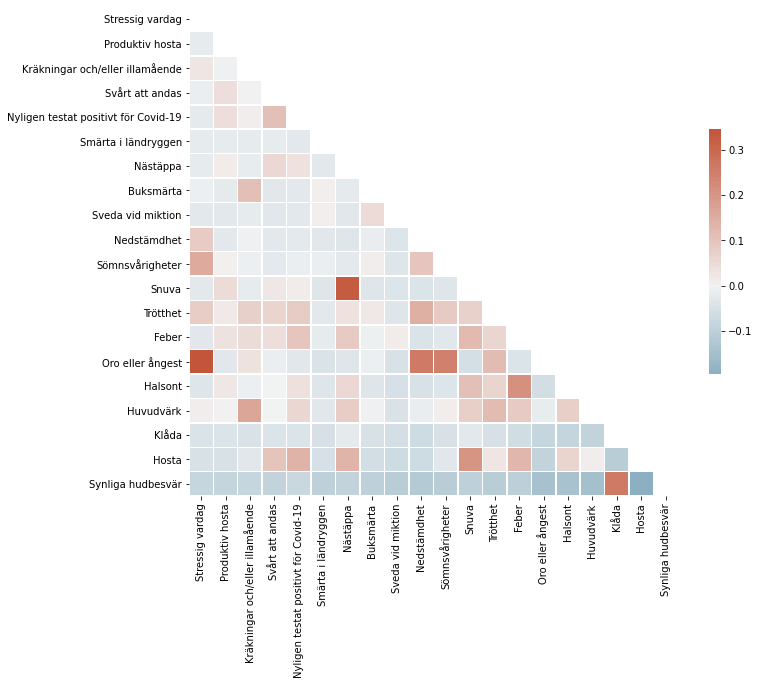

In [12]:
# create correlation matrix with chosen symptoms
#chosen_syms = ['Synliga hudbesvär', 'Hudbesvär', 'Feber', 'Snuva', 'Nästäppa', 'Huvudvärk', 'Hosta', 'Blodig hosta', 'Förstorad tunga']

# get the list of the n most common symptoms
n = 20

label_counts = np.sum(y, axis=0)
zipped = [(multilab_bin.classes_[i], label_counts[i]) for i in range(len(multilab_bin.classes_))]
zipped = sorted(zipped, key=lambda tup: tup[1])

chosen_syms = [tup[0] for tup in zipped[-n:]]

temp_labels = np.zeros((len(y),1))

for sym in chosen_syms:
    
    # variable to check if the symptom was found
    cur_len = temp_labels.shape[1]
    
    for i in range(len(multilab_bin.classes_)):
        if multilab_bin.classes_[i] == sym:
            temp_labels = np.concatenate((temp_labels, y[:,i].reshape(-1,1)), axis=1)
            break
    
    # check if the symptom was found
    if cur_len == temp_labels.shape[1]:
        print(f'Unable to find symptom: {sym}')
        
# remove the first column which is only zeros
temp_labels = temp_labels[:,1:]

if temp_labels.shape[1] != len(chosen_syms):
    print('Dimensions do not match number of symptoms')
            
# create dataframe containing the labels
lab_df = pd.DataFrame(temp_labels)
lab_df.columns = chosen_syms

# compute the correlation matrix
corr = lab_df.corr()

# only use absolute value of correlations
#corr = corr.abs()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# set up the matplotlib figure
#f, ax = plt.subplots(figsize=(11,9))
f, ax = plt.subplots(figsize=(11,9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
           square=True, linewidth=.5, cbar_kws={'shrink': .5})
    

In [13]:
# find counts of symptoms
syms = ['Blodig hosta', 'Förstorad tunga', 'Minnessvårigheter', 'Likgiltighet']

for i in range(len(multilab_bin.classes_)):
    if multilab_bin.classes_[i] in syms:
        print(f'{multilab_bin.classes_[i]}: {label_counts[i]}')

Blodig hosta: 11
Förstorad tunga: 2
Likgiltighet: 3
Minnessvårigheter: 19


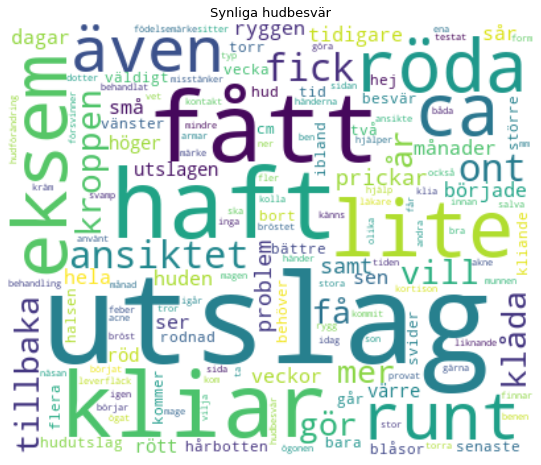

In [14]:
# create a WordCloud representation

# manually found stop-words
#stop_words = ['jag', 'har', 'med', 'och', 'att', 'på', 'men',
#             'är', 'som', 'det', 'inte', '']

stop_words = set(nltk.corpus.stopwords.words('swedish'))
#stop_words = []

# create new dataframe containing symptoms and texts that they occur in 
symtexts = []

for i in range(len(df)):
    text = clean_text(df['text'][i])
    
    # remove stop-words
    words = text.split()
    new_text = ''
    for w in words:
        if w not in stop_words:
            new_text += w + ' '
    text = new_text
    
    for sym in df['labels'][i]:
        symtexts.append([sym, text])
        
st_df = pd.DataFrame(symtexts, columns=['symptom', 'text'])

# make one row per symptom with all texts concatenated
st_df = st_df[['symptom', 'text']].groupby(by='symptom').agg(lambda x: ' '.join(x))

# create a Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(1,1), analyzer='word')
data = cv.fit_transform(st_df['text'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index = st_df.index
#df_dtm.head(3)


from wordcloud import WordCloud
from textwrap import wrap

# function for generating word clouds
def generate_wordcloud(data, title):
    wc = WordCloud(background_color='white', width=400, height=330, max_words=150).generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.show()
    
# transposing document term matrix
df_dtm = df_dtm.transpose()

# plot word cloud
sym = 'Synliga hudbesvär'
generate_wordcloud(df_dtm[sym].sort_values(ascending=False), sym)